# [T08] - Tugas Kelompok: Implementasi Generative Adversarial Network (GAN)

### kelompok
- Rizky Cahyono Putra - 442023611012
- 

## Konsep Dasar GAN
*Penjelasan Konseptual*: *Generative Adversarial Network* (GAN) adalah arsitektur deep learning yang terdiri dari dua jaringan saraf yang saling "berkompetisi".
1. **Generator (Si Pemalsu)**: Bertugas untuk membuat data palsu (dalam kasus ini, gambar pakaian) dari input acak (noise). Tujuannya adalah membuat data palsu yang sangat mirip dengan data asli hingga bisa menipu Discriminator.
2. **Discriminator (Si Detektif)**: Bertugas untuk membedakan antara data asli (dari dataset) dan data palsu (dari Generator). Tujuannya adalah menjadi sepintar mungkin dalam mendeteksi pemalsuan.
Melalui "perlombaan senjata" ini, Generator akan terus belajar hingga mampu menghasilkan gambar yang sangat realistis.

## Setup Awal Library
*Penjelasan*: Kita akan mengimpor **TensorFlow** untuk membangun model, **NumPy** untuk operasi numerik, dan **Matplotlib** untuk visualisasi. Kita juga mendefinisikan beberapa parameter utama seperti jumlah epoch, dimensi noise, dan ukuran batch.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import os

# konfig utama
EPOCHS = 100
NOISE_DIM = 100
BUFFER_SIZE = 60000
BATCH_SIZE = 256
SAVE_INTERVAL = 10

if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

E0000 00:00:1752319924.170903      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:230


## Memuat dan Mempersiapkan Dataset Fashion MNIST

*Penjelasan*: Kita memuat dataset Fashion MNIST menggunakan fungsi bawaan Keras. Langkah pra-pemrosesan sangat penting untuk GAN:
1. **Reshape**: Menambahkan dimensi channel pada gambar.
2. **Normalisasi**: Mengubah rentang nilai piksel dari [0, 255] menjadi [-1, 1]. Ini penting karena Generator akan menggunakan aktivasi tanh yang outputnya juga berada di rentang [-1, 1].

In [2]:
# load dataset online
(train_images, _), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

# menambahkan dimensi channel dan normalisasi gambar ke rentang [-1, 1]
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

# buat batch dataset dan shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(f"Dataset siap digunakan", {train_images.shape})

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1752319946.108455      10 service.cc:148] XLA service 0x575fb15dfd40 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752319946.108492      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1752319946.108497      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1752319946.108499      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1752319946.108504      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1752319946.108507      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1752319946.108509      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1752319946.108512      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1752319946.108515      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


Dataset siap digunakan {(60000, 28, 28, 1)}


## Membangun sel generator
*Penjelasan*: Generator mengambil vektor noise acak (NOISE_DIM) dan mengubahnya menjadi gambar 28x28x1. Ini dilakukan dengan proses upsampling menggunakan layer Conv2DTranspose.

In [3]:
def make_generator_model():
    model = tf.keras.Sequential()
    # vektor pertama merubah vektor noise menjadi basis gambar 7x7
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))

    # upsampling ke  14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # upsampling ke 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # outpur layer
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

generator = make_generator_model()
generator.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

## Membangun Model Descriminator
*Penjelasan*: Discriminator adalah model klasifikasi gambar (CNN) standar. Ia menerima gambar 28x28 dan menghasilkan satu nilai logit yang menentukan apakah gambar itu "asli" atau "palsu".

In [4]:
def make_descriminator_model():
    model = tf.keras.Sequential()
    # konvolusi
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # flaten dan output
    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

discriminator = make_descriminator_model()
discriminator.summary()

/usr/local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## Mendefinisikan Loss dan Optimizer
*Penjelasan*: Kita membutuhkan fungsi loss dan optimizer terpisah untuk kedua model. Kita menggunakan BinaryCrossentropy karena Discriminator pada dasarnya melakukan klasifikasi biner (asli vs palsu).

In [5]:
# fungsi loss 
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# optimizer 
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

# Fungsi Training Step
*Penjelasan*: Ini adalah inti dari loop training GAN. Dalam satu langkah, kita melatih Discriminator dan Generator secara bergantian. @tf.function digunakan untuk mengompilasi fungsi ini menjadi grafik TensorFlow yang berjalan jauh lebih cepat.

In [6]:
@tf.function
def train_step(images):
    #membuat noise acak
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, trainin=True)

        # discriminator menilai gambar asli dan palsu
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # menghitung loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # menghitung gradient
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        # Denormalisasi gambar dari [-1, 1] ke [0, 1] untuk ditampilkan
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig(f'generated_images/image_at_epoch_{epoch:04d}.png')
    plt.show()

# buat noise tetap untuk melihat evolusi gambar
seed = tf.random.normal([16, NOISE_DIM])

## Looping Training Utama
*Penjelasan*: Di sini kita menjalankan train_step berulang kali untuk setiap epoch. Kita juga akan menyimpan loss dan memanggil fungsi generate_and_save_images secara berkala untuk memantau kemajuan Generator.

Epoch 1, Gen Loss: 0.8649773001670837, Disc Loss: 1.2333028316497803, Waktu: 46.85 detik
Epoch 2, Gen Loss: 0.7911232709884644, Disc Loss: 1.363233208656311, Waktu: 41.66 detik
Epoch 3, Gen Loss: 0.8190542459487915, Disc Loss: 1.3492283821105957, Waktu: 41.78 detik
Epoch 4, Gen Loss: 0.8199083805084229, Disc Loss: 1.3514670133590698, Waktu: 41.13 detik
Epoch 5, Gen Loss: 0.8170493245124817, Disc Loss: 1.356637954711914, Waktu: 40.95 detik
Epoch 6, Gen Loss: 0.8328641653060913, Disc Loss: 1.3476121425628662, Waktu: 41.43 detik
Epoch 7, Gen Loss: 0.8481301665306091, Disc Loss: 1.3315895795822144, Waktu: 40.67 detik
Epoch 8, Gen Loss: 0.8441318869590759, Disc Loss: 1.3364464044570923, Waktu: 41.49 detik
Epoch 9, Gen Loss: 0.8461642861366272, Disc Loss: 1.3364346027374268, Waktu: 40.77 detik
Epoch 10, Gen Loss: 0.8462482690811157, Disc Loss: 1.339931845664978, Waktu: 40.80 detik


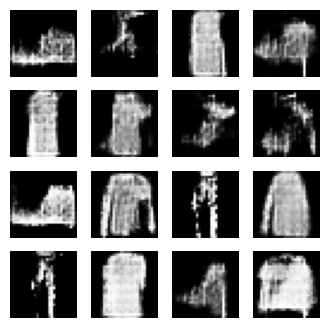

Epoch 11, Gen Loss: 0.8366321325302124, Disc Loss: 1.3513169288635254, Waktu: 40.41 detik
Epoch 12, Gen Loss: 0.830197811126709, Disc Loss: 1.3627957105636597, Waktu: 40.49 detik
Epoch 13, Gen Loss: 0.8200945258140564, Disc Loss: 1.3643171787261963, Waktu: 40.27 detik
Epoch 14, Gen Loss: 0.8239687085151672, Disc Loss: 1.365007758140564, Waktu: 40.24 detik
Epoch 15, Gen Loss: 0.8198367357254028, Disc Loss: 1.3636119365692139, Waktu: 40.53 detik
Epoch 16, Gen Loss: 0.8325173854827881, Disc Loss: 1.360611915588379, Waktu: 40.27 detik
Epoch 17, Gen Loss: 0.8228977918624878, Disc Loss: 1.3596265316009521, Waktu: 40.25 detik
Epoch 18, Gen Loss: 0.8208608031272888, Disc Loss: 1.3634451627731323, Waktu: 40.61 detik
Epoch 19, Gen Loss: 0.8200809955596924, Disc Loss: 1.3627607822418213, Waktu: 40.29 detik
Epoch 20, Gen Loss: 0.833849310874939, Disc Loss: 1.3616105318069458, Waktu: 40.22 detik


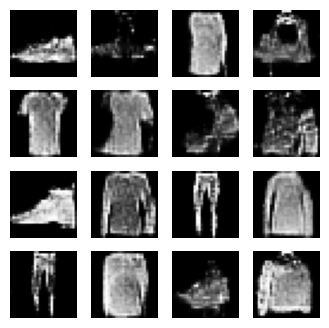

Epoch 21, Gen Loss: 0.8154928088188171, Disc Loss: 1.3633307218551636, Waktu: 40.31 detik
Epoch 22, Gen Loss: 0.8240994215011597, Disc Loss: 1.3624637126922607, Waktu: 40.53 detik
Epoch 23, Gen Loss: 0.8623805642127991, Disc Loss: 1.3507609367370605, Waktu: 40.81 detik
Epoch 24, Gen Loss: 0.8190346360206604, Disc Loss: 1.3596879243850708, Waktu: 40.55 detik
Epoch 25, Gen Loss: 0.8172156810760498, Disc Loss: 1.362718939781189, Waktu: 40.19 detik
Epoch 26, Gen Loss: 0.819682776927948, Disc Loss: 1.362964153289795, Waktu: 40.14 detik
Epoch 27, Gen Loss: 0.8186872601509094, Disc Loss: 1.3631199598312378, Waktu: 40.11 detik
Epoch 28, Gen Loss: 0.8188549876213074, Disc Loss: 1.3610303401947021, Waktu: 40.13 detik
Epoch 29, Gen Loss: 0.854162871837616, Disc Loss: 1.351771593093872, Waktu: 40.20 detik
Epoch 30, Gen Loss: 0.823925256729126, Disc Loss: 1.357784390449524, Waktu: 40.35 detik


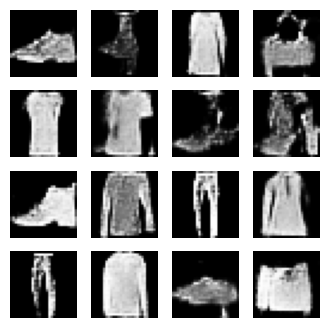

Epoch 31, Gen Loss: 0.816311240196228, Disc Loss: 1.3633379936218262, Waktu: 40.37 detik
Epoch 32, Gen Loss: 0.8193118572235107, Disc Loss: 1.3636184930801392, Waktu: 40.27 detik
Epoch 33, Gen Loss: 0.8283975720405579, Disc Loss: 1.3599629402160645, Waktu: 40.38 detik
Epoch 34, Gen Loss: 0.817622184753418, Disc Loss: 1.36271333694458, Waktu: 40.36 detik
Epoch 35, Gen Loss: 0.8219619393348694, Disc Loss: 1.3617050647735596, Waktu: 40.32 detik
Epoch 36, Gen Loss: 0.8212139010429382, Disc Loss: 1.3625391721725464, Waktu: 40.56 detik
Epoch 37, Gen Loss: 0.8443446755409241, Disc Loss: 1.3537030220031738, Waktu: 40.14 detik
Epoch 38, Gen Loss: 0.8165484666824341, Disc Loss: 1.3626106977462769, Waktu: 40.48 detik
Epoch 39, Gen Loss: 0.8180608153343201, Disc Loss: 1.3622242212295532, Waktu: 40.26 detik
Epoch 40, Gen Loss: 0.8163057565689087, Disc Loss: 1.3647781610488892, Waktu: 40.12 detik


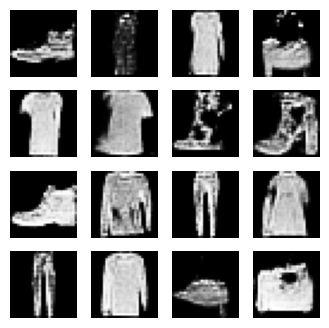

Epoch 41, Gen Loss: 0.8180297017097473, Disc Loss: 1.3631846904754639, Waktu: 40.01 detik
Epoch 42, Gen Loss: 0.8357205390930176, Disc Loss: 1.3582757711410522, Waktu: 40.02 detik
Epoch 43, Gen Loss: 0.8177695274353027, Disc Loss: 1.3630530834197998, Waktu: 40.29 detik
Epoch 44, Gen Loss: 0.8163865208625793, Disc Loss: 1.3640940189361572, Waktu: 40.27 detik
Epoch 45, Gen Loss: 0.8277541995048523, Disc Loss: 1.3608903884887695, Waktu: 40.01 detik
Epoch 46, Gen Loss: 0.8171643018722534, Disc Loss: 1.3639006614685059, Waktu: 40.34 detik
Epoch 47, Gen Loss: 0.822501540184021, Disc Loss: 1.3624062538146973, Waktu: 39.91 detik
Epoch 48, Gen Loss: 0.8242833018302917, Disc Loss: 1.3610584735870361, Waktu: 39.65 detik
Epoch 49, Gen Loss: 0.8168060779571533, Disc Loss: 1.3634963035583496, Waktu: 40.12 detik
Epoch 50, Gen Loss: 0.8197624683380127, Disc Loss: 1.3641839027404785, Waktu: 40.10 detik


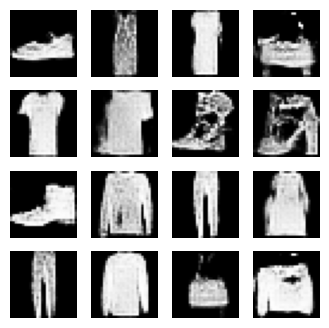

Epoch 51, Gen Loss: 0.8275920748710632, Disc Loss: 1.3602466583251953, Waktu: 39.63 detik
Epoch 52, Gen Loss: 0.8185718655586243, Disc Loss: 1.3622623682022095, Waktu: 39.81 detik
Epoch 53, Gen Loss: 0.8212884664535522, Disc Loss: 1.3632389307022095, Waktu: 40.42 detik
Epoch 54, Gen Loss: 0.8235205411911011, Disc Loss: 1.361759066581726, Waktu: 40.65 detik
Epoch 55, Gen Loss: 0.8188391327857971, Disc Loss: 1.3640787601470947, Waktu: 40.21 detik
Epoch 56, Gen Loss: 0.8273609280586243, Disc Loss: 1.359529972076416, Waktu: 40.37 detik
Epoch 57, Gen Loss: 0.829109251499176, Disc Loss: 1.360120177268982, Waktu: 40.10 detik
Epoch 58, Gen Loss: 0.817948043346405, Disc Loss: 1.3638534545898438, Waktu: 40.32 detik
Epoch 59, Gen Loss: 0.816412091255188, Disc Loss: 1.3649592399597168, Waktu: 39.99 detik
Epoch 60, Gen Loss: 0.8219870328903198, Disc Loss: 1.3634693622589111, Waktu: 40.01 detik


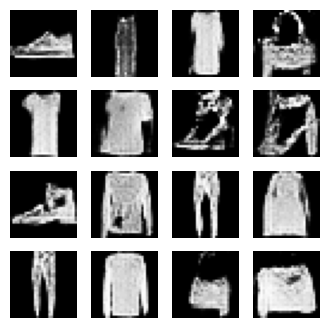

Epoch 61, Gen Loss: 0.8258850574493408, Disc Loss: 1.3612048625946045, Waktu: 40.07 detik
Epoch 62, Gen Loss: 0.819722592830658, Disc Loss: 1.3639609813690186, Waktu: 40.59 detik
Epoch 63, Gen Loss: 0.8194487690925598, Disc Loss: 1.3632937669754028, Waktu: 40.02 detik
Epoch 64, Gen Loss: 0.8256824612617493, Disc Loss: 1.3613362312316895, Waktu: 40.21 detik
Epoch 65, Gen Loss: 0.8245558738708496, Disc Loss: 1.3624266386032104, Waktu: 40.13 detik
Epoch 66, Gen Loss: 0.8195362687110901, Disc Loss: 1.3634052276611328, Waktu: 40.31 detik
Epoch 67, Gen Loss: 0.8240359425544739, Disc Loss: 1.3620617389678955, Waktu: 40.14 detik
Epoch 68, Gen Loss: 0.8225027918815613, Disc Loss: 1.3628346920013428, Waktu: 40.08 detik
Epoch 69, Gen Loss: 0.8231856822967529, Disc Loss: 1.3617686033248901, Waktu: 40.12 detik
Epoch 70, Gen Loss: 0.8220535516738892, Disc Loss: 1.363250732421875, Waktu: 40.04 detik


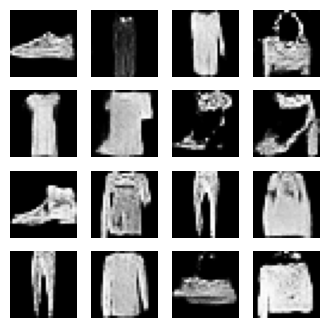

Epoch 71, Gen Loss: 0.8196019530296326, Disc Loss: 1.3634707927703857, Waktu: 39.87 detik
Epoch 72, Gen Loss: 0.8247855305671692, Disc Loss: 1.3628069162368774, Waktu: 39.93 detik
Epoch 73, Gen Loss: 0.8227850198745728, Disc Loss: 1.3619641065597534, Waktu: 40.20 detik
Epoch 74, Gen Loss: 0.8224644660949707, Disc Loss: 1.3634477853775024, Waktu: 40.26 detik
Epoch 75, Gen Loss: 0.8240360617637634, Disc Loss: 1.3626502752304077, Waktu: 40.02 detik
Epoch 76, Gen Loss: 0.8214621543884277, Disc Loss: 1.3622689247131348, Waktu: 40.16 detik
Epoch 77, Gen Loss: 0.8219843506813049, Disc Loss: 1.3636085987091064, Waktu: 40.38 detik
Epoch 78, Gen Loss: 0.8235479593276978, Disc Loss: 1.3613117933273315, Waktu: 40.37 detik
Epoch 79, Gen Loss: 0.825276255607605, Disc Loss: 1.3625489473342896, Waktu: 40.14 detik
Epoch 80, Gen Loss: 0.8224514722824097, Disc Loss: 1.362375259399414, Waktu: 40.38 detik


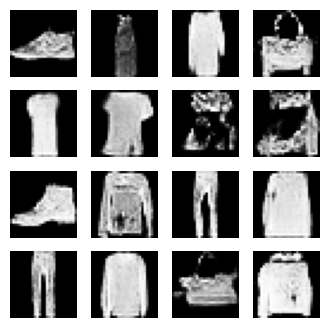

Epoch 81, Gen Loss: 0.8192180395126343, Disc Loss: 1.363322377204895, Waktu: 40.23 detik
Epoch 82, Gen Loss: 0.8284413814544678, Disc Loss: 1.3600190877914429, Waktu: 40.25 detik
Epoch 83, Gen Loss: 0.8207100629806519, Disc Loss: 1.3637815713882446, Waktu: 40.08 detik
Epoch 84, Gen Loss: 0.8247523903846741, Disc Loss: 1.362747311592102, Waktu: 40.06 detik
Epoch 85, Gen Loss: 0.8182429075241089, Disc Loss: 1.3641386032104492, Waktu: 39.94 detik
Epoch 86, Gen Loss: 0.8282091617584229, Disc Loss: 1.3611258268356323, Waktu: 39.92 detik
Epoch 87, Gen Loss: 0.8273512125015259, Disc Loss: 1.3605960607528687, Waktu: 40.02 detik
Epoch 88, Gen Loss: 0.8196665644645691, Disc Loss: 1.362951636314392, Waktu: 40.03 detik
Epoch 89, Gen Loss: 0.8185012340545654, Disc Loss: 1.3652405738830566, Waktu: 39.91 detik
Epoch 90, Gen Loss: 0.8235806226730347, Disc Loss: 1.3614612817764282, Waktu: 40.29 detik


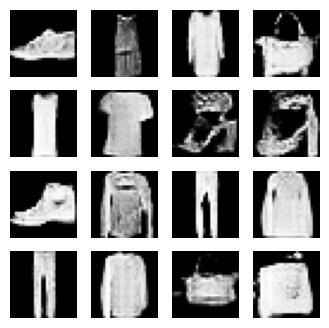

Epoch 91, Gen Loss: 0.8319568634033203, Disc Loss: 1.3589400053024292, Waktu: 40.16 detik
Epoch 92, Gen Loss: 0.8202012777328491, Disc Loss: 1.3643250465393066, Waktu: 40.29 detik
Epoch 93, Gen Loss: 0.8211559653282166, Disc Loss: 1.3630950450897217, Waktu: 40.11 detik
Epoch 94, Gen Loss: 0.823567807674408, Disc Loss: 1.362950325012207, Waktu: 40.40 detik
Epoch 95, Gen Loss: 0.8207911849021912, Disc Loss: 1.3624321222305298, Waktu: 40.31 detik
Epoch 96, Gen Loss: 0.8221379518508911, Disc Loss: 1.3644006252288818, Waktu: 39.94 detik
Epoch 97, Gen Loss: 0.8316227197647095, Disc Loss: 1.3580511808395386, Waktu: 40.35 detik
Epoch 98, Gen Loss: 0.8206242322921753, Disc Loss: 1.3640564680099487, Waktu: 40.12 detik
Epoch 99, Gen Loss: 0.8233431577682495, Disc Loss: 1.3634628057479858, Waktu: 39.98 detik
Epoch 100, Gen Loss: 0.8192302584648132, Disc Loss: 1.363315224647522, Waktu: 40.30 detik


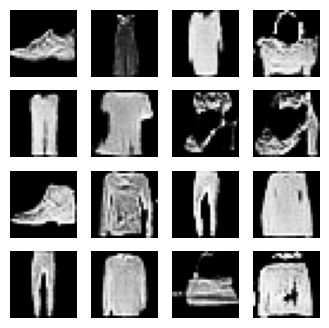

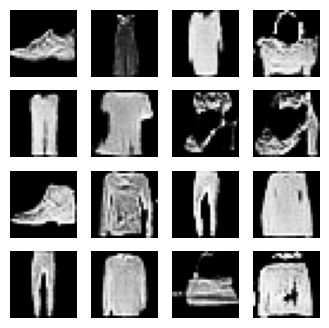

In [7]:
# mulai training
gen_loss_history = []
disc_loss_history = []

for epoch in range(EPOCHS):
    start = time.time()

    total_gen_loss = 0
    total_disc_loss = 0
    num_batches = 0

    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)
        total_gen_loss += g_loss
        total_disc_loss += d_loss
        num_batches += 1
    
    # Hitung rata-rata loss per epoch
    avg_gen_loss = total_gen_loss / num_batches
    avg_disc_loss = total_disc_loss / num_batches
    gen_loss_history.append(avg_gen_loss)
    disc_loss_history.append(avg_disc_loss)

    print(f'Epoch {epoch + 1}, Gen Loss: {avg_gen_loss}, Disc Loss: {avg_disc_loss}, Waktu: {time.time()-start:.2f} detik')

    # Hasilkan dan simpan gambar setiap interval yang ditentukan
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generate_and_save_images(generator, epoch + 1, seed)

# menghasilkan gambar terakhir
generate_and_save_images(generator, EPOCHS, seed)

## Visualisasi Loss
*Penjelasan*: Plotting loss dari Generator dan Discriminator dapat membantu kita memahami dinamika training. Idealnya, kedua loss ini mencapai keseimbangan dan tidak ada satu model yang "menang" telak atas yang lain.

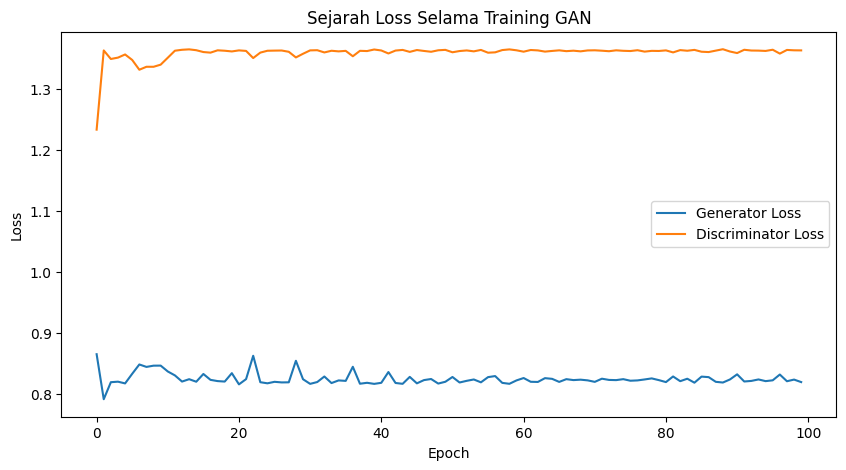

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(gen_loss_history, label='Generator Loss')
plt.plot(disc_loss_history, label='Discriminator Loss')
plt.title('Sejarah Loss Selama Training GAN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Analisis dan Refeleksi Kelompok
- **Analisis Hasil**: Dari gambar-gambar yang dihasilkan, terlihat jelas evolusi dari Generator. Pada *epoch* awal, outputnya hanyalah *noise* acak yang tidak berbentuk. Seiring berjalannya training, Generator mulai belajar struktur dasar dari dataset Fashion MNIST. Pada epoch akhir, kita dapat melihat bentuk-bentuk samar yang menyerupai item pakaian seperti sepatu, baju, dan celana, meskipun belum sempurna. Ini menunjukkan bahwa proses adversarial training telah berhasil.
- **Refelksi Proses**: Tantangan utama dalam melatih GAN adalah mencapai keseimbangan antara Generator dan Discriminator. Jika Discriminator menjadi terlalu pintar terlalu cepat, Generator tidak akan bisa belajar sama sekali (loss-nya akan stagnan). Sebaliknya, jika Generator terlalu mudah menipu Discriminator, hasilnya tidak akan realistis. Menemukan hyperparameter yang tepat (seperti learning rate) adalah kunci dan seringkali membutuhkan banyak eksperimen.
- **Pembelajaran**: Proyek ini memberikan pemahaman praktis yang mendalam tentang konsep kompetisi dalam deep learning. Kami belajar bagaimana dua jaringan dapat dilatih secara bersamaan untuk mencapai tujuan yang berlawanan, yang pada akhirnya menghasilkan kemampuan generatif yang luar biasa.